# AP HW4
## Efficient Frontier Revisited
> ### Part 1: Minimum-Tracking-Error Frontier

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

In [33]:
industry_portfolios = \
    pd\
    .read_csv("/Users/lu/Desktop/Industry_Portfolios.csv")

risk_factor =\
    pd\
    .read_csv("/Users/lu/Desktop/Risk_Factors.csv")

data = pd.merge(industry_portfolios, risk_factor, on='Date')

## <span style="color:red">计算超额收益</span>
### 
>计算每个行业组合相对于无风险利率的超额收益，CAPM模型假设投资者关心的是相对于无风险资产的超额收益，而不是绝对收益。因此，这一步计算了各行业组合的超额收益 Ri - Rf。

In [34]:
# excess return of market portfolio
industry_columns = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops', 'Hlth', 'Utils', 'Other']
for industry in industry_columns:
    data[industry] = data[industry] - data['Rf']

## <span style="color:red">计算各行业组合的期望偏离度（相对于市场组合的超额收益）</span>
####
> 对于每个行业，计算其相对于市场超额收益 Rm - Rf 的平均偏离度，表示行业组合的预期回报与市场基准回报的差距。这些偏离度用于构建最小跟踪误差组合。

##### expected deviation:
$$
R_i = E(\tilde{R}_i - \tilde{R}_m)
$$

In [35]:
# expected deviation from market return
expected_deviations = {}
for industry in industry_columns:
    expected_deviations [industry] = (data[industry] - data['Rm-Rf']).mean()

df = pd.DataFrame(expected_deviations.items(), columns=['Industry', 'Expected Deviation'])
df

,Industry,Expected Deviation
0,NoDur,0.154750
1,Durbl,-0.014750
2,Manuf,0.264750
3,Enrgy,0.483083
4,HiTec,0.018167
5,Telcm,0.133333
6,Shops,0.168250
7,Hlth,0.035750
8,Utils,0.159083
9,Other,-0.259000


In [36]:
num_points = len(df['Expected Deviation'])
R_p = np.linspace(0, 0.1, num_points) # 代表不同的预期收益偏离值，用于绘制最小跟踪误差边界曲线，表示在不同预期收益偏离值下组合的可能选择。

## <span style="color:red">构建偏离矩阵和协方差矩阵</span>
####
> 构建每个行业组合收益相对于市场组合收益的偏离矩阵，并计算其协方差矩阵。
> 偏离矩阵中的每一行表示每个行业组合在某一时期的收益偏离市场组合的程度。协方差矩阵用于描述各行业组合的偏离度之间的关系和波动性，帮助计算最小跟踪误差组合的权重。

##### covariance matrix of return deviations:
$$
V_{ij} = \text{Cov}[(\tilde{R}_i - \tilde{R}_m), (\tilde{R}_j - \tilde{R}_m)]
$$

In [37]:
deviation_matrix = data[industry_columns].subtract(data['Rm-Rf'], axis=0)

cov_matrix = deviation_matrix.cov()
cov_matrix_df = pd.DataFrame(cov_matrix, columns=industry_columns, index=industry_columns)

cov_matrix_df

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,5.439696,-6.073035,-1.396192,-1.200533,-1.883151,1.538885,1.140741,3.815137,4.272002,-1.768738
Durbl,-6.073035,26.628901,4.908024,-3.481055,1.891577,-1.707625,-0.354335,-8.082946,-9.617490,4.385865
Manuf,-1.396192,4.908024,2.950499,1.666133,0.065267,-0.626416,-1.154597,-2.288900,-1.901412,0.358904
Enrgy,-1.200533,-3.481055,1.666133,19.274911,-1.516972,-1.040525,-3.710439,-2.485796,4.454368,-3.864826
HiTec,-1.883151,1.891577,0.065267,-1.516972,5.098746,-0.773294,-0.245350,-1.936284,-2.342839,-1.404050
Telcm,1.538885,-1.707625,-0.626416,-1.040525,-0.773294,4.682567,0.463797,0.693157,2.721477,-1.271778
Shops,1.140741,-0.354335,-1.154597,-3.710439,-0.245350,0.463797,4.452628,0.764510,-0.176666,-0.256987
Hlth,3.815137,-8.082946,-2.288900,-2.485796,-1.936284,0.693157,0.764510,7.820446,3.496136,-1.726842
Utils,4.272002,-9.617490,-1.901412,4.454368,-2.342839,2.721477,-0.176666,3.496136,12.267476,-4.055112
Other,-1.768738,4.385865,0.358904,-3.864826,-1.404050,-1.271778,-0.256987,-1.726842,-4.055112,4.503204


## <span style="color:red">计算 alpha、zeta 和 delta</span>
####
> 计算常数 alpha、zeta 和 delta，这些常数在求解最小跟踪误差组合的权重和方差时会用到
> alpha、zeta 和 delta 是通过矩阵运算得出的标量，它们在计算最小跟踪误差组合的风险和收益时非常重要

In [38]:
R = np.array(list(expected_deviations.values()), dtype=float)# 期望偏离度向量
V = cov_matrix_df.values# 协方差矩阵
e = np.ones(len(expected_deviations))# 单位向量，用于简化矩阵运算
# print(type(R))

In [39]:
inv_V = np.linalg.inv(V)

In [57]:
alpha = np.dot(np.dot(R.T, inv_V), e)
print("\nalpha=",alpha)
zeta = np.dot(np.dot(R.T, inv_V), R)
print("\nzeta =",zeta)
delta = np.dot(np.dot(e.T, inv_V), e)
print("\ndelta =",delta)


alpha= 2.9321278826306285

zeta = 0.2047449735113006

delta = 58.550254376399124


## <span style="color:red">计算最小跟踪误差组合的权重</span>
####
> 计算最小跟踪误差组合的权重
> 该权重公式确保组合的期望回报与市场组合尽可能接近，同时最小化跟踪误差。这些权重表示在最小跟踪误差组合中每个行业组合的分配比例

##### Weights for Minimum-Tracking-Error Portfolio:
$$
w* = \frac{V^{-1} R}{\mathbf{1}^T V^{-1} R}
$$

In [41]:
weights = np.dot(inv_V, R) / np.dot(np.dot(e, inv_V), R)
weights_df = pd.DataFrame(weights, index=industry_columns, columns=['Weights'])
weights_df

,Weights
NoDur,0.052634
Durbl,0.000153
Manuf,0.137627
Enrgy,0.087032
HiTec,0.179353
Telcm,0.071074
Shops,0.106884
Hlth,0.102776
Utils,0.040162
Other,0.222304


## <span style="color:red">计算跟踪误差</span>
####
> 计算每个行业组合的跟踪误差。\
> 跟踪误差通常指的是组合回报与基准回报之间的波动程度，这里通过协方差矩阵的对角线元素（即各组合自身的方差）来估计。

##### Tracking Error:
$$
\text{Tracking Error} = \sqrt{\text{variance}}
$$

In [42]:
variance = np.diag(cov_matrix)
df['Tracking Error'] = np.sqrt(variance)
df

,Industry,Expected Deviation,Tracking Error
0,NoDur,0.154750,2.332316
1,Durbl,-0.014750,5.160320
2,Manuf,0.264750,1.717702
3,Enrgy,0.483083,4.390320
4,HiTec,0.018167,2.258040
5,Telcm,0.133333,2.163924
6,Shops,0.168250,2.110125
7,Hlth,0.035750,2.796506
8,Utils,0.159083,3.502496
9,Other,-0.259000,2.122075


## <span style="color:red">绘制最小跟踪误差边界</span>
####
> 绘制最小跟踪误差边界。\
> 根据之前计算的 delta 和 zeta，将不同预期回报下的跟踪误差绘制成曲线，表示构建满足不同收益水平的组合时最小化跟踪误差的边界。

#### Plot the minimum-tracking-error frontier generated by the ten industry portfolios.

In [43]:
R_p = np.arange(0, 0.101, 0.005)

min_track_error_frontier = pd.DataFrame(R_p, columns=['Rp'])

min_track_error_frontier['sd'] = np.sqrt(1 / delta + (delta / (zeta * delta - alpha ** 2)) * (R_p - alpha / delta) ** 2)
# min_track_error_frontier

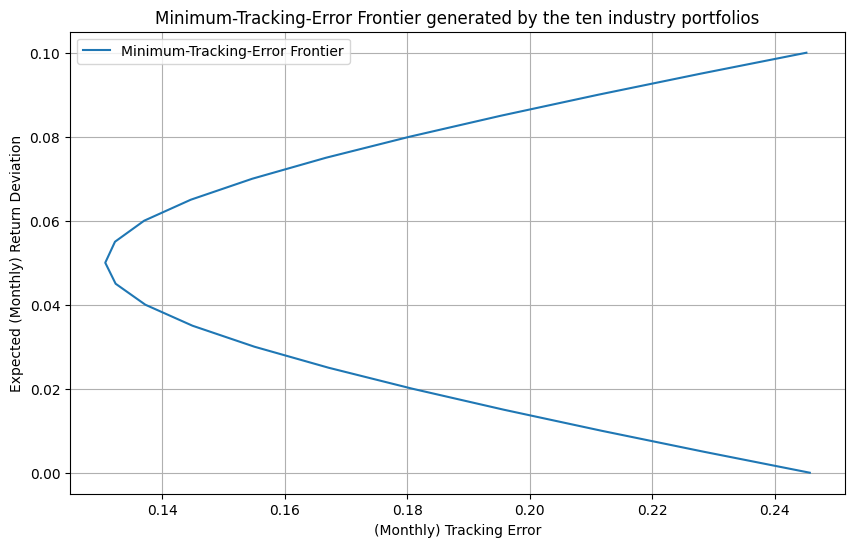

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(min_track_error_frontier['sd'], min_track_error_frontier['Rp'], label='Minimum-Tracking-Error Frontier')
plt.xlabel('(Monthly) Tracking Error')
plt.ylabel('Expected (Monthly) Return Deviation')
plt.title('Minimum-Tracking-Error Frontier generated by the ten industry portfolios')
plt.grid(True)
plt.legend()
plt.show()

## <span style="color:red">计算信息比率（Information Ratio）</span>
####
> 1. 计算每个预期收益对应的跟踪误差边界上的信息比率，并找到信息比率最高的切线组合\
> 2. 信息比率衡量组合的风险调整后回报。信息比率最大的组合（切线组合）表示在给定跟踪误差水平下的最佳回报

##### Information Ratio:
$$
\text{IR} = \frac{\text{Expected Deviation}}{\text{Tracking Error}}
$$

In [45]:
min_track_error_frontier['IR'] = min_track_error_frontier['Rp'] / min_track_error_frontier['sd']
# find the max of IR that is tangency portfolio
tangency_portfolio = min_track_error_frontier.loc[min_track_error_frontier['IR'].idxmax()]
information_ratio = tangency_portfolio['IR']
print("\ninformation_ratio =", information_ratio)


information_ratio = 0.45248408073659774


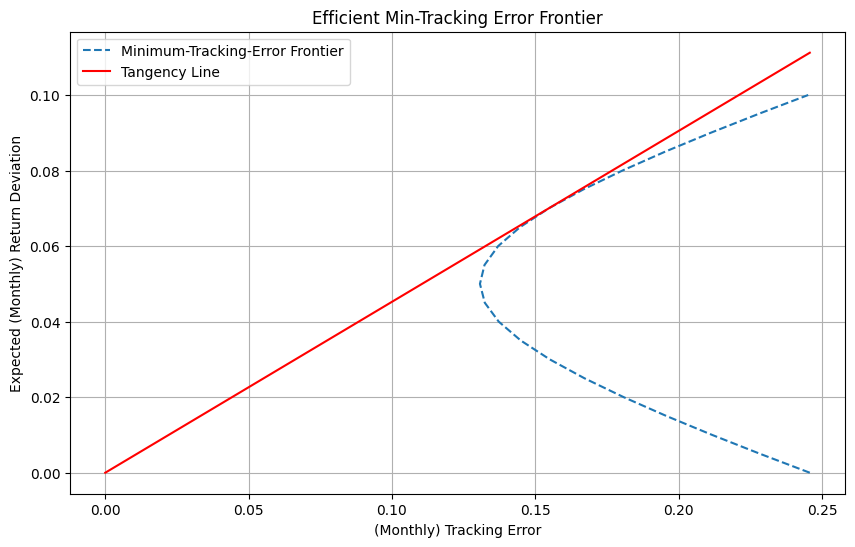

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(min_track_error_frontier['sd'], min_track_error_frontier['Rp'], linestyle='--', label='Minimum-Tracking-Error Frontier')

# Tangency Line
slope = tangency_portfolio['IR']# IR
x_vals = np.linspace(0, max(min_track_error_frontier['sd']), 100)
y_vals = slope * x_vals
plt.plot(x_vals, y_vals, label='Tangency Line', color='red')
plt.xlabel('(Monthly) Tracking Error')
plt.ylabel('Expected (Monthly) Return Deviation')
plt.title('Efficient Min-Tracking Error Frontier')
plt.grid(True)
plt.legend()
plt.show()

## <span style="color:red">无空头限制的最小方差边界</span>

> ### Part 2: Minimum-Variance Frontier w/o Short Sales

### <span style="color:blue">1. 数据处理</span>

In [65]:
#### > 1. 准备数据以计算无空头限制的最小方差边界。
#### > 2. 这里去掉日期列并计算每个行业的平均收益和协方差矩阵，作为构建最小方差边界的基础。
new_data =\
    industry_portfolios.drop(columns = ['Date'])
mean_returns = new_data[industry_columns].mean()
mean_returns_df = pd.DataFrame(mean_returns, columns=['Mean Return'])
# mean_returns_df

In [66]:
cov_matrix = data[industry_columns].cov()
cov_matrix_df = pd.DataFrame(cov_matrix, columns=industry_columns, index=industry_columns)
# cov_matrix_df

### <span style="color:blue">2. 随机生成权重组合</span>
> 生成随机组合权重，满足权重之和为1的条件。\
> 解释：无空头限制意味着每个资产的权重必须为非负，且所有资产权重之和为1。


In [67]:
def generate_weights(num_portfolios, num_assets):
    weights = np.random.rand(num_portfolios, num_assets)
    weights /= weights.sum(axis=1)[:, np.newaxis]
    return weights

### <span style="color:blue">3. 计算组合收益和风险</span>
###
> 计算组合的平均收益和标准差。\
> 解释：通过给定权重组合、平均收益和协方差矩阵，计算组合的预期收益和风险（标准差）。

In [54]:
def portfolio_statistics(weights, mean_returns_df, cov_matrix_df):
    mean_return = np.dot(weights, mean_returns_df)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_df, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return mean_return, portfolio_std_dev

### <span style="color:blue">4. 绘制无空头限制的最小方差边界</span>
###
> 作用: 生成大量组合，并绘制无空头限制的最小方差边界。\
> 解释：
    > 1. 通过生成多个随机组合，计算每个组合的风险和收益并绘制散点图，展示无空头限制条件下可能的最小方差边界。
    > 2. generate_weights(num_portfolios, num_assets) 函数生成了 100,000 个随机权重组合（每个组合包含 10 个资产）。
    > 3. 对每个权重组合，使用 portfolio_statistics 函数计算其平均收益和标准差，并分别存入 portfolio_returns 和 portfolio_risks 列表中。这些收益和风险值将用于绘制无空头限制的最小方差边界。
    > 4. 绘制散点图

> 含义:\
> 展示了在无空头限制的条件下，各种可能的权重组合的风险-收益分布，形成了最小方差边界。\
图中的点越靠左下角，组合的风险越低，即最小方差组合。\
投资者可以在这些组合中选择最优的风险-收益匹配。

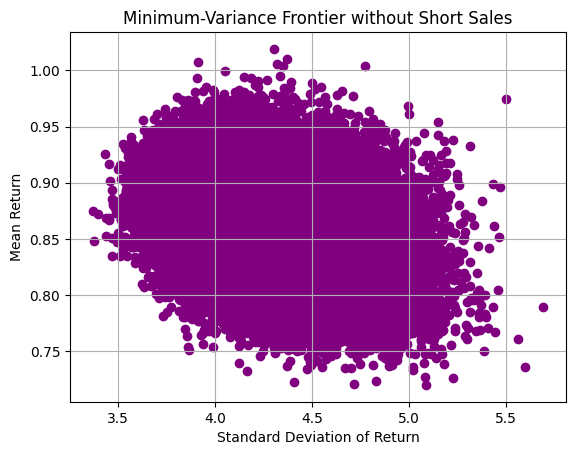

In [55]:
num_portfolios = int(1e5)
num_assets = 10

weights = generate_weights(num_portfolios, num_assets)
portfolio_returns = []
portfolio_risks = []

# mean and standard deviation for each portfolio
for w in weights:
    mean_return, std_dev = portfolio_statistics(w, mean_returns_df, cov_matrix_df)
    portfolio_returns.append(mean_return)
    portfolio_risks.append(std_dev)

plt.scatter(portfolio_risks, portfolio_returns, c='purple', marker='o')# 绘制了每个组合的风险和收益的散点图。
plt.xlabel('Standard Deviation of Return') #组合的风险（标准差
plt.ylabel('Mean Return')# 组合的平均收益
plt.title('Minimum-Variance Frontier without Short Sales')
plt.grid(True)
plt.show()

### <span style="color:blue">5. 反向权重的最小方差边界</span>
###
> 这个图展示了在反向权重条件下，各种可能的权重组合的风险-收益分布，形成了另一种最小方差边界。\
> 反向权重扩大了权重空间，可能包含更多偏离标准的组合，通常用于测试边界的稳健性。\
> 这种最小方差边界显示了在不同条件下的组合选择，与无空头限制的最小方差边界对比，可以观察到权重设置对组合风险和收益的影响。

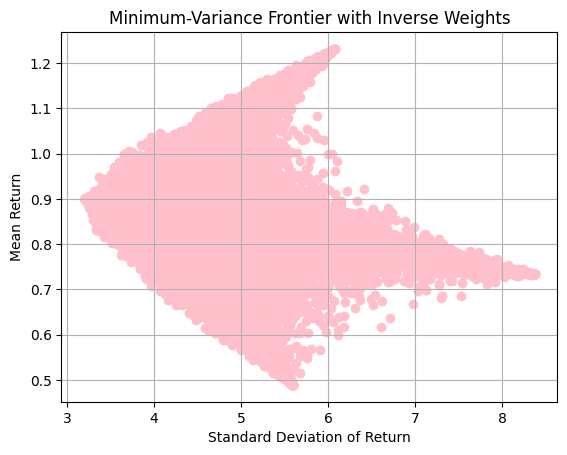

In [56]:
# 生成反向权重组合：
inverse_weights = 1 / np.random.rand(num_portfolios, num_assets)# 创建了权重为随机数倒数的组合，以扩大组合的权重空间。
inverse_weights /= inverse_weights.sum(axis=1)[:, np.newaxis]# 将每个组合的权重归一化，使得权重之和为1。

# 计算组合的平均收益和风险：对于每个生成的反向权重组合，计算其平均收益和标准差，并将结果分别存储到 
portfolio_returns_inv = []
portfolio_risks_inv = []

for w in inverse_weights:
    mean_return, std_dev = portfolio_statistics(w, mean_returns_df, cov_matrix_df)
    portfolio_returns_inv.append(mean_return)
    portfolio_risks_inv.append(std_dev)
    
# 绘制了这些反向权重组合的风险和收益的散点图：
plt.scatter(portfolio_risks_inv, portfolio_returns_inv, c='pink', marker='o')
plt.xlabel('Standard Deviation of Return')# 组合的风险（标准差）
plt.ylabel('Mean Return')# 组合的平均收益
plt.title('Minimum-Variance Frontier with Inverse Weights')
plt.grid(True)
plt.show()